# Анализ поведения пользователя мобильного приложения

Цель исследования: разобраться, как ведут себя пользователи данного мобильного приложения, а также проверить, как влияет изменение дизайна страниц (другой шрифт)  на поведение пользователей. 

In [54]:
import pandas as pd
from scipy import stats as st
import numpy as np
import math as mth
from plotly import graph_objects as go 
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import kaleido
import warnings
warnings.filterwarnings("ignore")

## Обзор файла и подготовка данных

In [55]:
logs = pd.read_csv('logs_exp.csv',sep='\t')
logs.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


- EventName — название события;
- DeviceIDHash — уникальный идентификатор пользователя;
- EventTimestamp — время события;
- ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

In [56]:
logs=logs.rename(columns = {'EventName': 'event','DeviceIDHash': 'device','EventTimestamp': 'event_timestamp','ExpId': 'nn'})

In [57]:
logs.head()

,event,device,event_timestamp,nn
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [58]:
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
event              244126 non-null object
device             244126 non-null int64
event_timestamp    244126 non-null int64
nn                 244126 non-null int64
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [59]:
n_users0 = logs['device'].nunique()
n_users0

7551

In [60]:
n_evens0 = len(logs)
n_evens0

244126

Сделаем ряд проверок на корректность данных. По info() видно, что пропущенных значений нет. Проверим на дубли.

In [61]:
logs.duplicated().sum()

413

In [62]:
logs = logs.drop_duplicates().reset_index(drop=True) 

Пришлось удалить 413 записей как дубли. Дата события event_timestamp дана в секундах. Маловероятно, что в одну секунду было сделано 2 одинаковых действия. Хотя количество этих записей меньше 1% от общего числа, они все равно не оказали бы большого влияния на результаты.

добавим колонки с датами

In [63]:
logs['event_datetime'] = pd.to_datetime(logs['event_timestamp'],unit='s')

logs['event_date'] = logs['event_datetime'].dt.date

In [64]:
logs.head()

,event,device,event_timestamp,nn,event_datetime,event_date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


Посмотрим диапазон дат логов.

In [65]:
logs['event_date'].max()

datetime.date(2019, 8, 7)

In [66]:
logs['event_date'].min()

datetime.date(2019, 7, 25)

Посмотрим графически

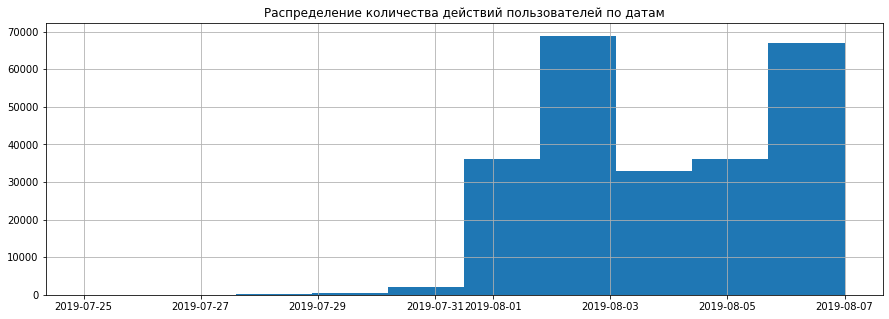

In [67]:
logs['event_date'].hist(figsize=(15,5)).set_title('Распределение количества действий пользователей по датам');

Посчитаем количество действий по дням

In [68]:
logs['event_date'].value_counts()

2019-08-01    36141
2019-08-05    36058
2019-08-06    35788
2019-08-02    35554
2019-08-03    33282
2019-08-04    32968
2019-08-07    31096
2019-07-31     2030
2019-07-30      412
2019-07-29      184
2019-07-28      105
2019-07-27       55
2019-07-26       31
2019-07-25        9
Name: event_date, dtype: int64

Оставим только данные за август

In [69]:
logs = logs[logs['event_date'] >= pd.to_datetime('2019-08-01')]
logs['event_date'].value_counts()

2019-08-01    36141
2019-08-05    36058
2019-08-06    35788
2019-08-02    35554
2019-08-03    33282
2019-08-04    32968
2019-08-07    31096
Name: event_date, dtype: int64

In [70]:
logs

,event,device,event_timestamp,nn,event_datetime,event_date
2826,Tutorial,3737462046622621720,1564618048,246,2019-08-01 00:07:28,2019-08-01
2827,MainScreenAppear,3737462046622621720,1564618080,246,2019-08-01 00:08:00,2019-08-01
2828,MainScreenAppear,3737462046622621720,1564618135,246,2019-08-01 00:08:55,2019-08-01
2829,OffersScreenAppear,3737462046622621720,1564618138,246,2019-08-01 00:08:58,2019-08-01
2830,MainScreenAppear,1433840883824088890,1564618139,247,2019-08-01 00:08:59,2019-08-01
...,...,...,...,...,...,...
243708,MainScreenAppear,4599628364049201812,1565212345,247,2019-08-07 21:12:25,2019-08-07
243709,MainScreenAppear,5849806612437486590,1565212439,246,2019-08-07 21:13:59,2019-08-07
243710,MainScreenAppear,5746969938801999050,1565212483,246,2019-08-07 21:14:43,2019-08-07
243711,MainScreenAppear,5746969938801999050,1565212498,246,2019-08-07 21:14:58,2019-08-07


In [71]:
n_users = logs['device'].nunique()
n_evens = len(logs)
print('Удалено записей:',n_evens0-n_evens,';  % =',round((n_evens0-n_evens)/n_evens0*100,2),'%')
print('Удалено пользователей:',n_users0-n_users,';  % =',round((n_users0-n_users)/n_users0*100,2),'%')


Удалено записей: 3239 ;  % = 1.33 %
Удалено пользователей: 17 ;  % = 0.23 %


Посмотрим  нет ли пересечений и равноценны ли группы

In [72]:
g246 = logs[logs['nn']==246]
g247 = logs[logs['nn']==247]
g248 = logs[logs['nn']==248]

users246 = g246['device'].nunique()
users247 = g247['device'].nunique()
users248 = g248['device'].nunique()
users249 = users246 + users247

In [73]:
g246.merge(g247,on='device',how='inner')
g247.merge(g248,on='device',how='inner')
g246.merge(g248,on='device',how='inner')

,event_x,device,event_timestamp_x,nn_x,event_datetime_x,event_date_x,event_y,event_timestamp_y,nn_y,event_datetime_y,event_date_y


Во всех случаях пересечение пусто.

In [74]:
print(users246,users247,users248)
print(len(g246),len(g247),len(g248))

2484 2513 2537
79302 77022 84563


In [75]:
print('Количество событий',len(logs))
print('Количество пользователей',logs['device'].nunique())
print('Среднее количество событий на пользователя',round(len(logs)/logs['device'].nunique(),2))

Количество событий 240887
Количество пользователей 7534
Среднее количество событий на пользователя 31.97


**Заключение по разделу** В этом разделе была произведена подготовка данных для расчета. Удалены дубли, определен период полных данных,удалены записи периода с неполными данными, исключены случаи пересечения событий групп, получены общие суммарные значения параметров файла. Всего было удалено 3239 записи, в том числе среди них 17 уникальных пользователей.

## Воронка событий

Посмотрим какие события есть в логах

In [76]:
events_count = logs['event'].value_counts()

In [77]:
users_count = logs.groupby('event').agg({'device': 'nunique'}).sort_values(by='device', ascending=False)

users_count

,device
event,
MainScreenAppear,7419
OffersScreenAppear,4593
CartScreenAppear,3734
PaymentScreenSuccessful,3539
Tutorial,840


In [78]:
users_MainScreenAppear = users_count.loc['MainScreenAppear','device']
users_OffersScreenAppear = users_count.loc['OffersScreenAppear','device']
users_CartScreenAppear = users_count.loc['CartScreenAppear','device']
users_PaymentScreenSuccessful = users_count.loc['PaymentScreenSuccessful','device']
users_Tutorial = users_count.loc['Tutorial','device']

MainScreenAppear -> OffersScreenAppear -> CartScreenAppear -> PaymentScreenSuccessful

Должна выстраиваться такая основная цепочка событий.(Невозможно выбрать товар, не открыв первую страницу или оплатить товар, не положив его в корзину). Но при этом на любом этапе пользователь может обратиться в Справку (Tutorial). Примечание: Если на сайте есть возможность зайти по ссылке на конкретный товар или сразу в сохраненную корзину, то эта цепочка укорачивается.

Посчитаем долю пользователей на каждом этапе

In [79]:
part_MainScreenAppear = round((users_MainScreenAppear/logs['device'].nunique()),2)
part_OffersScreenAppear = round((users_OffersScreenAppear/logs['device'].nunique()),2)
part_CartScreenAppear = round((users_CartScreenAppear/logs['device'].nunique()),2)
part_PaymentScreenSuccessful = round((users_PaymentScreenSuccessful/logs['device'].nunique()),2)
part_Tutorial = round((users_Tutorial/logs['device'].nunique()),2)
print(part_MainScreenAppear,'',part_OffersScreenAppear,'',part_CartScreenAppear,'',part_PaymentScreenSuccessful,'', part_Tutorial)

0.98  0.61  0.5  0.47  0.11


Посчитаем доли пользователей, которые переходят на следующий этап 

In [80]:
step_OffersScreenAppear = round((users_OffersScreenAppear/users_MainScreenAppear),2)
step_CartScreenAppear = round((users_CartScreenAppear/users_OffersScreenAppear),2)
step_PaymentScreenSuccessful = round((users_PaymentScreenSuccessful/users_CartScreenAppear),2)
print('1.0','',step_OffersScreenAppear,'',step_CartScreenAppear,'',step_PaymentScreenSuccessful)

1.0  0.62  0.81  0.95


In [81]:
print('До оплаты доходят', round((users_PaymentScreenSuccessful/logs['device'].nunique()),2))

До оплаты доходят 0.47


Представим это графически:

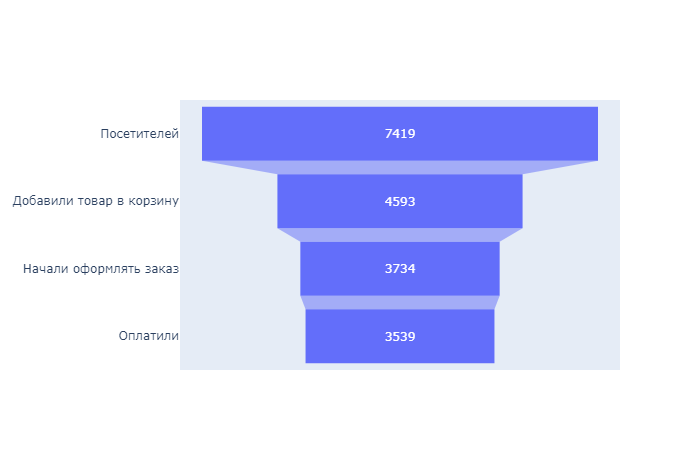

In [82]:
fig = go.Figure(
    go.Funnel(
        y=[
            'Посетителей',
            'Добавили товар в корзину',
            'Начали оформлять заказ',
            'Оплатили',
        ],
        x=[7419, 4593, 3734, 3539],
    )
)
fig.show('png') 

**Заключение по разделу** В этом разделе была построена воронка событий действий пользователей.

## Результаты эксперимента

Соберем результаты эксперимента по группам, посчитаем количество пользователей, выполнивших определенное действие

In [83]:
users_groups = logs.pivot_table(
    index='nn', columns='event', values='device', aggfunc='nunique')
users_groups

event,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial
nn,,,,,
246,1266,2450,1542,1200,278
247,1238,2476,1520,1158,283
248,1230,2493,1531,1181,279


Добавим четвертую объединенную группу.

In [84]:
d249 = pd.DataFrame({'CartScreenAppear': users_groups.loc[246,'CartScreenAppear']+users_groups.loc[247,'CartScreenAppear'],
                     'MainScreenAppear': users_groups.loc[246,'MainScreenAppear']+users_groups.loc[247,'MainScreenAppear'],
                     'OffersScreenAppear': users_groups.loc[246,'OffersScreenAppear']+users_groups.loc[247,'OffersScreenAppear'],
                     'PaymentScreenSuccessful': users_groups.loc[246,'PaymentScreenSuccessful']+users_groups.loc[247,'PaymentScreenSuccessful'],
                     'Tutorial': users_groups.loc[246,'Tutorial']+users_groups.loc[247,'Tutorial']},index=[249])
d249

,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial
249,2504,4926,3062,2358,561


In [85]:
users_groups = users_groups.append(d249,sort=False)
users_groups

event,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial
246,1266,2450,1542,1200,278
247,1238,2476,1520,1158,283
248,1230,2493,1531,1181,279
249,2504,4926,3062,2358,561


Создадим столбец количества людей в группах

In [86]:
total_users_group=pd.Series([users246,users247,users248,users249],index=[246,247,248,249])


Посчитаем доли людей, выполнивших определенное действие

In [87]:
part_users_groups=users_groups.div(total_users_group, axis='index', level=None, fill_value=None)
part_users_groups

event,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial
246,0.509662,0.986312,0.620773,0.483092,0.111916
247,0.492638,0.985277,0.604855,0.460804,0.112614
248,0.484825,0.982657,0.603469,0.465510,0.109972
249,0.501101,0.985791,0.612768,0.471883,0.112267


In [88]:
part_users_groups = part_users_groups.reindex(columns=['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear','PaymentScreenSuccessful','Tutorial'])
part_users_groups

event,MainScreenAppear,OffersScreenAppear,CartScreenAppear,PaymentScreenSuccessful,Tutorial
246,0.986312,0.620773,0.509662,0.483092,0.111916
247,0.985277,0.604855,0.492638,0.460804,0.112614
248,0.982657,0.603469,0.484825,0.465510,0.109972
249,0.985791,0.612768,0.501101,0.471883,0.112267


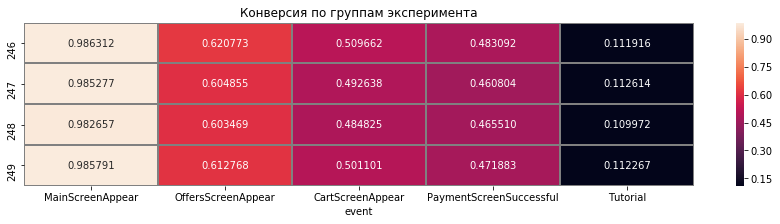

In [89]:
plt.figure(figsize=(15, 3))
plt.title('Конверсия по группам эксперимента')
sns.set_style ({'text.color': '.01','xtick.color':'0.001','ytick.color':'0.001'})
sns.heatmap(part_users_groups, annot=True, fmt='.6f', linewidths=1, linecolor='gray') 

In [90]:
part_users_groups2=part_users_groups.T
part_users_groups2

,246,247,248,249
event,,,,
MainScreenAppear,0.986312,0.985277,0.982657,0.985791
OffersScreenAppear,0.620773,0.604855,0.603469,0.612768
CartScreenAppear,0.509662,0.492638,0.484825,0.501101
PaymentScreenSuccessful,0.483092,0.460804,0.465510,0.471883
Tutorial,0.111916,0.112614,0.109972,0.112267


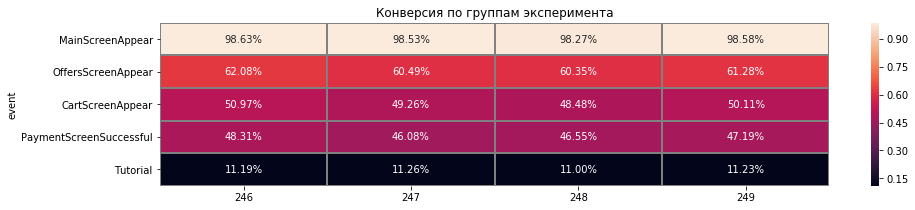

In [91]:
plt.figure(figsize=(15, 3))
plt.title('Конверсия по группам эксперимента')
sns.heatmap(part_users_groups2, annot=True, fmt='.2%', linewidths=1, linecolor='gray') 

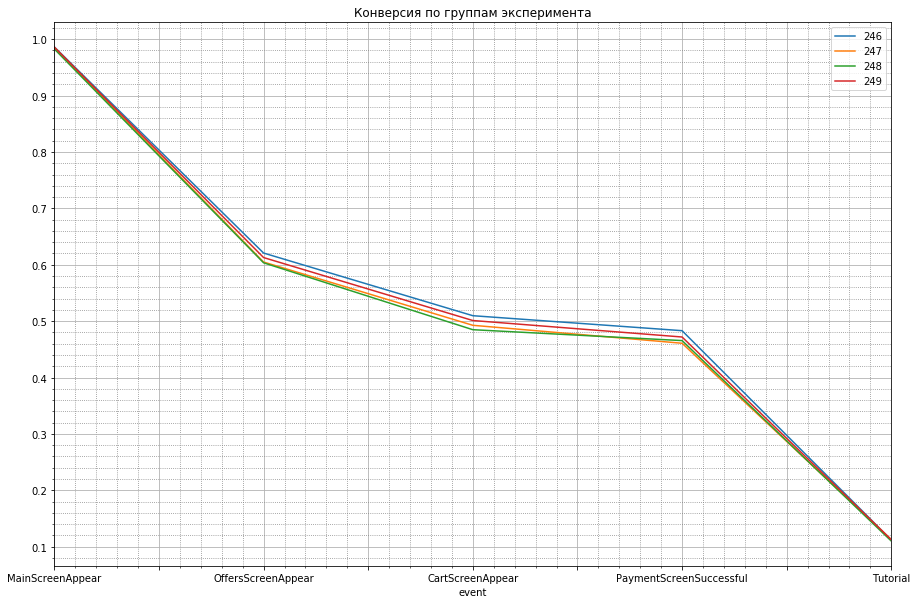

In [92]:

ax=part_users_groups2.plot(figsize=(15,10),grid=True,title='Конверсия по группам эксперимента')
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.02))
ax.minorticks_on()
ax.grid(which='minor',
        color = 'gray',
        linestyle = ':')



**Заключение по разделу** В этом разделе были получены сводные таблицы по результатам эксперимента для групп.

## Проверка гипотезы о равенстве долей

Нулевая гипотеза: конверсии в тестовой и контрольных группах равны.

Альтернативная: конверсии в тестовой и контрольных группах имеют статистически значимое отличие.

Применим z-test. Чтобы снизить вероятность ложнопозитивного результата при множественном тестировании гипотез, применим поправку Бонферрони.

In [93]:
def z_test (alpha,ind1,ind2,column,n):
    p1=part_users_groups.loc[ind1,column]
    p2=part_users_groups.loc[ind2,column]
    p_combined = (users_groups.loc[ind1,column] + users_groups.loc[ind2,column]) / (total_users_group[ind1] + total_users_group[ind2])
    difference = p1 - p2
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/total_users_group[ind1] + 1/total_users_group[ind2]))
    distr = st.norm(0, 1) 
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    bonferroni_alpha=alpha/n
    print('------------------------------------------------------------')
    print(bonferroni_alpha,'(Вonferroni)',ind1,ind2,column,'при n=',n)
    if p_value < bonferroni_alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')
    
    return print('p_value=',p_value)

где alpha - уровень значимости, n - количество сравнений, ind1,ind2 - индекс строки таблицы

Установим уровень значимости alpha=0.05, проведем 4 сравнения.

In [94]:
z_test(0.05,246,247,'MainScreenAppear',4)
z_test(0.05,246,247,'OffersScreenAppear',4)
z_test(0.05,246,247,'CartScreenAppear',4)
z_test(0.05,246,247,'PaymentScreenSuccessful',4)
z_test(0.05,246,247,'Tutorial',4)


------------------------------------------------------------
0.0125 (Вonferroni) 246 247 MainScreenAppear при n= 4
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p_value= 0.7570597232046099
------------------------------------------------------------
0.0125 (Вonferroni) 246 247 OffersScreenAppear при n= 4
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p_value= 0.2480954578522181
------------------------------------------------------------
0.0125 (Вonferroni) 246 247 CartScreenAppear при n= 4
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p_value= 0.22883372237997213
------------------------------------------------------------
0.0125 (Вonferroni) 246 247 PaymentScreenSuccessful при n= 4
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p_value= 0.11456679313141849
------------------------------------------------------------
0.0125 (Вonferroni) 246 247 Tutorial при n= 

In [95]:
z_test(0.05,248,246,'MainScreenAppear',4)
z_test(0.05,248,246,'OffersScreenAppear',4)
z_test(0.05,248,246,'CartScreenAppear',4)
z_test(0.05,248,246,'PaymentScreenSuccessful',4)
z_test(0.05,248,246,'Tutorial',4)

------------------------------------------------------------
0.0125 (Вonferroni) 248 246 MainScreenAppear при n= 4
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p_value= 0.2949721933554552
------------------------------------------------------------
0.0125 (Вonferroni) 248 246 OffersScreenAppear при n= 4
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p_value= 0.20836205402738917
------------------------------------------------------------
0.0125 (Вonferroni) 248 246 CartScreenAppear при n= 4
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p_value= 0.07842923237520116
------------------------------------------------------------
0.0125 (Вonferroni) 248 246 PaymentScreenSuccessful при n= 4
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p_value= 0.2122553275697796
------------------------------------------------------------
0.0125 (Вonferroni) 248 246 Tutorial при n= 

In [96]:
z_test(0.05,248,247,'MainScreenAppear',4)
z_test(0.05,248,247,'OffersScreenAppear',4)
z_test(0.05,248,247,'CartScreenAppear',4)
z_test(0.05,248,247,'PaymentScreenSuccessful',4)
z_test(0.05,248,247,'Tutorial',4)

------------------------------------------------------------
0.0125 (Вonferroni) 248 247 MainScreenAppear при n= 4
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p_value= 0.4587053616621515
------------------------------------------------------------
0.0125 (Вonferroni) 248 247 OffersScreenAppear при n= 4
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p_value= 0.9197817830592261
------------------------------------------------------------
0.0125 (Вonferroni) 248 247 CartScreenAppear при n= 4
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p_value= 0.5786197879539783
------------------------------------------------------------
0.0125 (Вonferroni) 248 247 PaymentScreenSuccessful при n= 4
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p_value= 0.7373415053803964
------------------------------------------------------------
0.0125 (Вonferroni) 248 247 Tutorial при n= 4


In [97]:
z_test(0.05,248,249,'MainScreenAppear',4)
z_test(0.05,248,249,'OffersScreenAppear',4)
z_test(0.05,248,249,'CartScreenAppear',4)
z_test(0.05,248,249,'PaymentScreenSuccessful',4)
z_test(0.05,248,249,'Tutorial',4)

------------------------------------------------------------
0.0125 (Вonferroni) 248 249 MainScreenAppear при n= 4
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p_value= 0.29424526837179577
------------------------------------------------------------
0.0125 (Вonferroni) 248 249 OffersScreenAppear при n= 4
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p_value= 0.43425549655188256
------------------------------------------------------------
0.0125 (Вonferroni) 248 249 CartScreenAppear при n= 4
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p_value= 0.18175875284404386
------------------------------------------------------------
0.0125 (Вonferroni) 248 249 PaymentScreenSuccessful при n= 4
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p_value= 0.6004294282308704
------------------------------------------------------------
0.0125 (Вonferroni) 248 249 Tutorial при n=

Как показывают расчеты, во всех сравнениях пар групп не отвергается нулевая гипотеза, что доли равны, ни для ни одного события. 

Уменьшим уровень значимости alpha = 0.01

In [98]:
z_test(0.01,246,247,'MainScreenAppear',4)
z_test(0.01,246,247,'OffersScreenAppear',4)
z_test(0.01,246,247,'CartScreenAppear',4)
z_test(0.01,246,247,'PaymentScreenSuccessful',4)
z_test(0.01,246,247,'Tutorial',4)

------------------------------------------------------------
0.0025 (Вonferroni) 246 247 MainScreenAppear при n= 4
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p_value= 0.7570597232046099
------------------------------------------------------------
0.0025 (Вonferroni) 246 247 OffersScreenAppear при n= 4
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p_value= 0.2480954578522181
------------------------------------------------------------
0.0025 (Вonferroni) 246 247 CartScreenAppear при n= 4
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p_value= 0.22883372237997213
------------------------------------------------------------
0.0025 (Вonferroni) 246 247 PaymentScreenSuccessful при n= 4
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p_value= 0.11456679313141849
------------------------------------------------------------
0.0025 (Вonferroni) 246 247 Tutorial при n= 

In [99]:
z_test(0.01,248,246,'MainScreenAppear',4)
z_test(0.01,248,246,'OffersScreenAppear',4)
z_test(0.01,248,246,'CartScreenAppear',4)
z_test(0.01,248,246,'PaymentScreenSuccessful',4)
z_test(0.01,248,246,'Tutorial',4)

------------------------------------------------------------
0.0025 (Вonferroni) 248 246 MainScreenAppear при n= 4
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p_value= 0.2949721933554552
------------------------------------------------------------
0.0025 (Вonferroni) 248 246 OffersScreenAppear при n= 4
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p_value= 0.20836205402738917
------------------------------------------------------------
0.0025 (Вonferroni) 248 246 CartScreenAppear при n= 4
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p_value= 0.07842923237520116
------------------------------------------------------------
0.0025 (Вonferroni) 248 246 PaymentScreenSuccessful при n= 4
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p_value= 0.2122553275697796
------------------------------------------------------------
0.0025 (Вonferroni) 248 246 Tutorial при n= 

In [100]:
z_test(0.01,248,247,'MainScreenAppear',4)
z_test(0.01,248,247,'OffersScreenAppear',4)
z_test(0.01,248,247,'CartScreenAppear',4)
z_test(0.01,248,247,'PaymentScreenSuccessful',4)
z_test(0.01,248,247,'Tutorial',4)

------------------------------------------------------------
0.0025 (Вonferroni) 248 247 MainScreenAppear при n= 4
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p_value= 0.4587053616621515
------------------------------------------------------------
0.0025 (Вonferroni) 248 247 OffersScreenAppear при n= 4
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p_value= 0.9197817830592261
------------------------------------------------------------
0.0025 (Вonferroni) 248 247 CartScreenAppear при n= 4
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p_value= 0.5786197879539783
------------------------------------------------------------
0.0025 (Вonferroni) 248 247 PaymentScreenSuccessful при n= 4
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p_value= 0.7373415053803964
------------------------------------------------------------
0.0025 (Вonferroni) 248 247 Tutorial при n= 4


In [101]:
z_test(0.01,248,249,'MainScreenAppear',4)
z_test(0.01,248,249,'OffersScreenAppear',4)
z_test(0.01,248,249,'CartScreenAppear',4)
z_test(0.01,248,249,'PaymentScreenSuccessful',4)
z_test(0.01,248,249,'Tutorial',4)

------------------------------------------------------------
0.0025 (Вonferroni) 248 249 MainScreenAppear при n= 4
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p_value= 0.29424526837179577
------------------------------------------------------------
0.0025 (Вonferroni) 248 249 OffersScreenAppear при n= 4
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p_value= 0.43425549655188256
------------------------------------------------------------
0.0025 (Вonferroni) 248 249 CartScreenAppear при n= 4
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p_value= 0.18175875284404386
------------------------------------------------------------
0.0025 (Вonferroni) 248 249 PaymentScreenSuccessful при n= 4
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p_value= 0.6004294282308704
------------------------------------------------------------
0.0025 (Вonferroni) 248 249 Tutorial при n=

При коэффициенте 0.01 получен тот же результат.

**Заключение по разделу** В этом разделе был проведен расчет z-теста по результатам эксперимента при уровнях значимости 0.05 и 0.01 с учетом поправки Бонферрони.

## Общий вывод

-   В процессе этого исследования была рассчитана воронка событий действий пользователей. Оплату товара совершают 47% пользователей от общего количества.
-   Были получены сводные таблицы по результатам эксперимента.
-   При расчете z-теста при уровнях значимости alpha=0.05 и alpha=0.01, не было получено статистически значимое отличие тестовой и контрольных групп для событий. А значит, что несмотря на результаты сводных таблиц, где посчитанная конверсия имеет небольшие различия по группам, можно сделать вывод, что изменение шрифта не повлияло на поведение пользователей. 